# Sentiment Analysis

In [1]:
import pandas as pd
import zipfile
import os
import re
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from wordcloud import WordCloud

# Ensure you have the necessary NLTK resources
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\milto\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Extract the dataset
zip_file_path = 'Social Media Sentiments.zip'
extraction_dir = 'extracted_files'

try:
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extraction_dir)
    print(f"Files extracted successfully to {extraction_dir}")
except FileNotFoundError:
    print(f"Error: The file '{zip_file_path}' was not found.")
except Exception as e:
    print(f"An error occurred while extracting the zip file: {e}")

# Define the path to the CSV file after extraction
csv_file_path = os.path.join(extraction_dir, 'sentimentdataset.csv')

Files extracted successfully to extracted_files


In [3]:
# Load the dataset
try:
    data = pd.read_csv(csv_file_path)
    print("\nData loaded successfully. First few rows:")
    print(data.head())
except FileNotFoundError:
    print(f"Error: The file '{csv_file_path}' was not found.")
except Exception as e:
    print(f"An error occurred while loading the CSV file: {e}")



Data loaded successfully. First few rows:
   Unnamed: 0.1  Unnamed: 0  \
0             0           0   
1             1           1   
2             2           2   
3             3           3   
4             4           4   

                                                Text    Sentiment  \
0   Enjoying a beautiful day at the park!        ...   Positive     
1   Traffic was terrible this morning.           ...   Negative     
2   Just finished an amazing workout! 💪          ...   Positive     
3   Excited about the upcoming weekend getaway!  ...   Positive     
4   Trying out a new recipe for dinner tonight.  ...   Neutral      

             Timestamp            User     Platform  \
0  2023-01-15 12:30:00   User123          Twitter     
1  2023-01-15 08:45:00   CommuterX        Twitter     
2  2023-01-15 15:45:00   FitnessFan      Instagram    
3  2023-01-15 18:20:00   AdventureX       Facebook    
4  2023-01-15 19:55:00   ChefCook        Instagram    

                        

In [4]:
# Clean the text column
def clean_text(text):
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'\@\w+|\#', '', text)  # Remove @mentions and hashtags
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = text.lower()  # Convert to lowercase
    text = ' '.join(word for word in text.split() if word not in stop_words)  # Remove stopwords
    return text

data['Cleaned_Text'] = data['Text'].apply(lambda x: clean_text(str(x)))


In [5]:
# Simplify sentiment labels and ensure we only focus on Positive, Neutral, Negative
# Clean the Sentiment column more thoroughly
data['Sentiment'] = data['Sentiment'].str.strip()

# Update the simplify_sentiment function
def simplify_sentiment(sentiment):
    """Refine sentiment categorization with a more flexible matching."""
    positive_sentiments = ['Joy', 'Happiness', 'Excitement', 'Admiration', 'Gratitude', 'Elation', 'Pride', 'Love', 'Amusement', 'Enjoyment', 'Affection', 'Awe', 'Surprise', 'Acceptance', 'Adoration', 'Anticipation', 'Zest', 'Hopeful', 'Proud', 'Grateful', 'Empathetic', 'Compassionate', 'Playful', 'Free-spirited', 'Inspired', 'Confident', 'Optimism', 'Enchantment', 'Intrigue', 'PlayfulJoy', 'Mindfulness', 'Adventure', 'Melodic', 'FestiveJoy', 'InnerJourney', 'Freedom', 'Dazzle', 'Adrenaline', 'ArtisticBurst', 'CulinaryOdyssey', 'Resilience', 'Immersion', 'Spark', 'Marvel', 'Celebration', 'Charm', 'Ecstasy', 'Colorful', 'Hypnotic', 'Connection', 'Iconic', 'Journey', 'Engagement', 'Touched', 'Triumph', 'Heartwarming', 'Obstacle', 'Sympathy', 'Pressure', 'Renewed Effort', 'Miscalculation', 'Challenge', 'Solace', 'Breakthrough', 'JoyfulReunion', 'Inspiration', 'Motivation', 'Satisfaction', 'Blessed', 'Reflection', 'Appreciation', 'Confidence', 'Accomplishment', 'Wonderment', 'Amazement', 'Romance', 'Captivation', 'Tranquility', 'Grandeur', 'Emotion', 'Energy', 'Celebration']
    negative_sentiments = ['Anger', 'Fear', 'Sadness', 'Disgust', 'Frustration', 'Betrayal', 'Despair', 'Grief', 'Loneliness', 'Jealousy', 'Resentment', 'Anxiety', 'Intimidation', 'Helplessness', 'Envy', 'Regret', 'Curiosity', 'Indifference', 'Numbness', 'Melancholy', 'Nostalgia', 'Ambivalence', 'Bitterness', 'Yearning', 'Fearful', 'Apprehensive', 'Jealous', 'Devastated', 'Frustrated', 'Envious', 'Dismissive', 'Bittersweet', 'Overjoyed', 'Overwhelmed', 'Frustration', 'Heartbreak', 'Betrayal', 'Suffering', 'EmotionalStorm', 'Isolation', 'Disappointment', 'LostLove', 'Exhaustion', 'Sorrow', 'Darkness', 'Desperation', 'Ruins', 'Desolation', 'Loss', 'Heartache', 'Solitude', 'Heartbreak', 'Regret', 'Sad', 'Hate', 'Bad']
    neutral_sentiments = ['Neutral', 'Calmness', 'Contentment', 'Serenity', 'Reflection', 'Peace', 'Bliss', 'Mindfulness', 'Hope', 'Fulfillment', 'Tenderness', 'Reverence', 'Satisfaction', 'Indifference', 'Solace', 'Nostalgia', 'Tranquility', 'Balance', 'Wonder', 'Gratitude']

    # If sentiment matches one of the categories, return the corresponding sentiment
    sentiment = sentiment.strip()  # Remove leading/trailing spaces
    if sentiment in positive_sentiments:
        return 'Positive'
    elif sentiment in negative_sentiments:
        return 'Negative'
    elif sentiment in neutral_sentiments:
        return 'Neutral'
    else:
        return 'Neutral'  # Default to 'Neutral' if sentiment doesn't match

# Apply the sentiment simplification
data['Simplified_Sentiment'] = data['Sentiment'].apply(simplify_sentiment)

# Check the updated sentiment distribution
print("\nUpdated Simplified Sentiment Distribution:")
print(data['Simplified_Sentiment'].value_counts())



Updated Simplified Sentiment Distribution:
Simplified_Sentiment
Positive    279
Neutral     251
Negative    202
Name: count, dtype: int64


In [8]:
# Split the data into features (X) and target (y)
X = data['Cleaned_Text']
y = data['Simplified_Sentiment']

# Encode target labels as numeric values
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Train-Test Split (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Convert Text to TF-IDF Features
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Check class distribution before SMOTE
print("\nClass distribution in the training set before SMOTE:")
print(pd.Series(y_train).value_counts())


Class distribution in the training set before SMOTE:
2    231
1    201
0    153
Name: count, dtype: int64



Classification Report:
              precision    recall  f1-score   support

    Negative       0.85      0.82      0.83        49
     Neutral       0.64      0.54      0.59        50
    Positive       0.62      0.75      0.68        48

    accuracy                           0.70       147
   macro avg       0.70      0.70      0.70       147
weighted avg       0.71      0.70      0.70       147


Confusion Matrix:


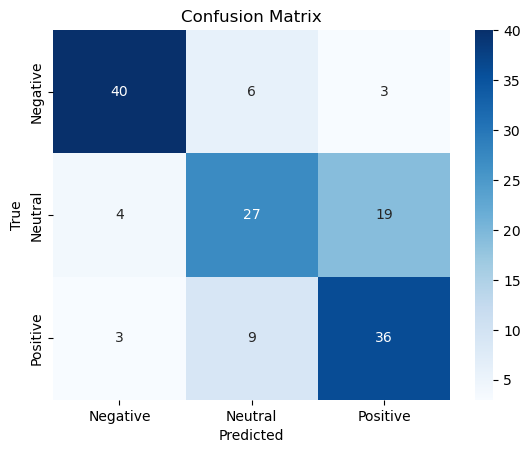


Accuracy: 0.7007


In [9]:
# Ensure SMOTE is applied correctly to the TF-IDF features

# Apply SMOTE (after TF-IDF transformation)
smote = SMOTE(random_state=42)
X_train_tfidf_resampled, y_train_resampled = smote.fit_resample(X_train_tfidf, y_train)

# Train Logistic Regression Model
model = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
model.fit(X_train_tfidf_resampled, y_train_resampled)

# Model Prediction
y_pred = model.predict(X_test_tfidf)

# Evaluate the Model
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Accuracy Score
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.4f}")

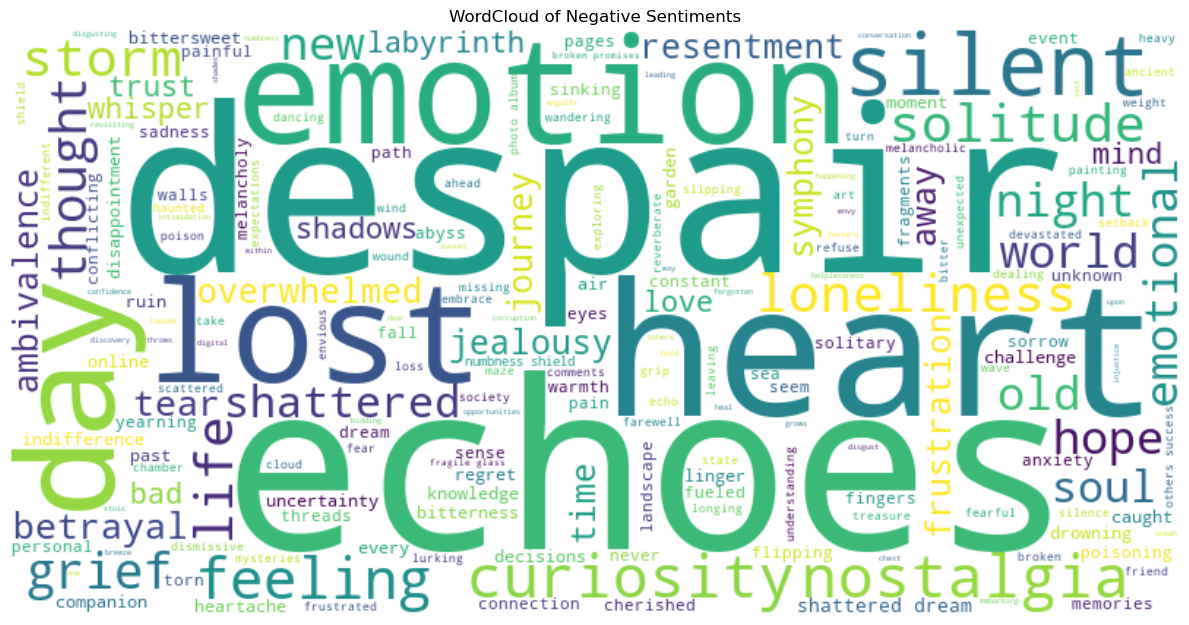

In [10]:
# Sentiment Analysis on Negative Reviews (Highlight common themes)
negative_reviews = data[data['Simplified_Sentiment'] == 'Negative']['Cleaned_Text']

# Generate a WordCloud for Negative Sentiments
negative_text = ' '.join(negative_reviews)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_text)

plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud of Negative Sentiments")
plt.tight_layout()
plt.show()